# Deep Learning: More Convolutional Neural Networks

Welcome back! Today’s small–group lecture explores **Convolutional Neural Networks (CNNs)**, building directly on what we've learned so far in deep learning.

CNNs are the workhorse behind many modern computer vision systems — from image classification (e.g., recognizing cats vs. dogs) to object detection (e.g., detecting pedestrians in self-driving cars) and even style transfer.

In a standard fully-connected neural network, every neuron in one layer connects to every neuron in the next. That works well for tabular data, but it ignores the fact that **images have spatial structure**: nearby pixels tend to be related. CNNs exploit this by using small filters (kernels) that slide over the image to detect local patterns like edges and textures.

By the end of this session, you will be able to:
- Understand the intuition behind CNNs and why they work so well for image data.
- Understand the syntax used to write a multi-layer PyTorch CNN.
- Explain the role of activation functions, batch normalization, and max pooling.
- Train, validate, and analyze a CNN’s performance.
- Understand core training concepts such as optimizers, loss functions, epochs, and learning rate.

This lecture is designed to feel like a guided walkthrough — with explanations of not just **what** we do, but **why** we do it. As you go, try to connect the code to the mathematical ideas from lecture.

Let's begin!

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

print(f"Pytorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Pytorch version: 2.9.1+cpu
Torchvision version: 0.24.1+cpu


In [3]:
%pip install torch torchvision torchaudio matplotlib tqdm

   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   - -------------------------------------- 5.2/110.9 MB 31.7 MB/s eta 0:00:04
   ----- ---------------------------------- 14.2/110.9 MB 36.3 MB/s eta 0:00:03
   -------- ------------------------------- 23.9/110.9 MB 39.3 MB/s eta 0:00:03
   ---------- ----------------------------- 30.4/110.9 MB 37.0 MB/s eta 0:00:03
   -------------- ------------------------- 40.4/110.9 MB 38.8 MB/s eta 0:00:02
   ----------------- ---------------------- 49.8/110.9 MB 37.9 MB/s eta 0:00:02
   --------------------- ------------------ 60.8/110.9 MB 39.7 MB/s eta 0:00:02
   ------------------------- -------------- 70.3/110.9 MB 40.2 MB/s eta 0:00:02
   --------------------------- ------------ 77.6/110.9 MB 40.3 MB/s eta 0:00:01
   ------------------------------- -------- 87.6/110.9 MB 38.4 MB/s eta 0:00:01
   ---------------------------------- ----- 96.2/110.9 MB 38.9 MB/s eta 0:00:01
   ------------------------------------- - 107.2/1

### Note: Python must be 3.11.x

If your kernel shows a value > 3.11.x you will need to downgrade. Please email the staff for help.

**Why does this matter?** Deep learning frameworks like PyTorch provide precompiled binaries (called *wheels*) for specific Python versions and hardware setups. When Python introduces a new major/minor version (like 3.12), the internal binary interface (ABI) can change. If PyTorch hasn't released a compatible wheel yet, you may see runtime errors, crashes, or import failures.

So as a rule of thumb:
- Always check the PyTorch install page for supported Python versions.
- If you see version mismatches, try creating a **conda or venv environment** with Python 3.11 specifically for deep learning work.

In this class, we standardize on **Python 3.11.x** so the environment is reproducible and supportable.

In [3]:
# DEVICE CONFIGURATION
if torch.backends.mps.is_available():          # Apple Silicon (Metal Performance Shaders)
    device = torch.device("mps")
elif torch.cuda.is_available():                # NVIDIA GPU with CUDA
    device = torch.device("cuda")
else:
    device = torch.device("cpu")               # Fallback to CPU

print("Using device:", device)

Using device: cpu


For today's small group, we will walk through the process of setting up a convolutional neural network ("CNN" for short) using the `pytorch` package!

CNNs shine when working with **structured grid data**, especially images — tasks like classification, segmentation, object detection, and more.

Why? Because CNNs:
- Capture local patterns (edges, textures) via **convolutions**.
- Build hierarchical features (shapes → object parts → full objects) through **stacked layers**.
- Use **shared weights**, meaning the same filter is applied across the whole image, which makes them parameter-efficient and **translation-equivariant** (shifting the image shifts the feature map in a predictable way).

### Quick Mental Picture 🖼️
- Early layers learn to detect **edges** and simple textures.
- Middle layers detect **parts** like eyes, wheels, or wings.
- Later layers detect **semantic concepts** like "dog", "car", or "bird".

Let’s load a dataset so we can see these ideas in action.

Recall from lecture that CNNs are generally used to process gridded data or images.

Let's begin by loading one of the toy datasets included in `pytorch`: **CIFAR-10**.

The dataset contains 60,000 small 32×32 color images belonging to 10 different classes:
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

There are 50,000 training images and 10,000 test images. Each image has **3 color channels (RGB)** and a relatively low resolution (32×32), which makes it great for teaching and small experiments.

We will also apply a **transform pipeline** to preprocess the images before feeding them into the network.

In [4]:
# init preprocessing for CIFAR-10 dataset (images are 32x32x3)
transform = transforms.Compose([
    transforms.ToTensor(),
    # ToTensor() converts images from [0, 255] uint8 to [0.0, 1.0] float32
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize each channel to roughly [-1, 1]
])

In [5]:
batch_size = 100
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Great! We have image data now. But what does it look like?

Visualizing your data is an essential first step — especially in computer vision. It's very easy to accidentally:
- Misinterpret labels.
- Apply the wrong preprocessing.
- Feed the network images that are rotated, upside-down, or poorly scaled.

Let's plot the different classes below using `matplotlib`. When working with the visualizations, consider:
- *What patterns do you notice?* (e.g., background colors, viewpoints, clutter)
- *Which classes might be harder for the network? Why?* (e.g., cat vs. dog may be harder than airplane vs. frog)

You are encouraged to:
- Sample a batch from `train_loader`.
- Show a grid of images.
- Print the corresponding class names.

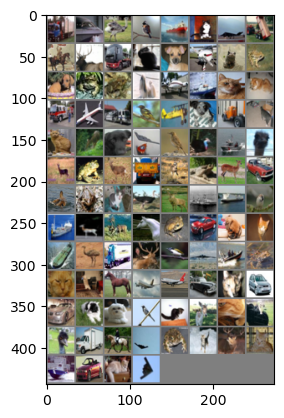

truck plane bird  bird  ship  cat   plane truck


In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt
import numpy as np
import torchvision

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

## Building a CNN

Conceptually, our CNN will:
1. Take a 3×32×32 image.
2. Apply a series of convolution + nonlinearity + pooling operations that gradually reduce spatial size but increase the number of feature maps.
3. Flatten the final feature maps into a vector.
4. Feed that vector into a fully connected layer that outputs **logits** for the 10 CIFAR-10 classes.

The figure below shows a high-level diagram of a CNN:

<p align="left">
    <img src = "https://media.geeksforgeeks.org/wp-content/uploads/20250529121802516451/Convolutional-Neural-Network-in-Machine-Learning.webp" width = "500">
</p>

### Activation Functions

Activation functions introduce **nonlinearity** into the network, which allows the model to approximate complex functions.

Some common activation functions:

- **ReLU** (Rectified Linear Unit): `f(x) = max(0, x)`
  - Very simple, fast to compute.
  - Avoids vanishing gradients on the positive side.
  - TensorFlow equivalents: `tf.nn.relu` or `tf.keras.layers.ReLU()`.

- **LeakyReLU**: `f(x) = x` if `x > 0`, and `αx` otherwise (α is small, like 0.01).
  - Solves the "dying ReLU" problem by allowing a small negative gradient.
  - TensorFlow: `tf.nn.leaky_relu`.

- **Tanh**: squashes values to (-1, 1).
  - Zero-centered, which can help optimization.
  - Still suffers from saturation/vanishing gradients at large |x|.
  - TensorFlow: `tf.nn.tanh` or `tf.keras.activations.tanh`.

Without nonlinear activations, a stack of layers collapses to a single linear transformation — so no matter how many layers you add, the overall function is still just a linear mapping. Nonlinear activations give the network the ability to approximate **complex nonlinear functions**.

Below is a simple CNN model in PyTorch:

In [7]:
# Define a simple CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Input shape: (batch_size, 3, 32, 32)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),        # -> (batch_size, 32, 32, 32)
            nn.BatchNorm2d(32),                                # normalize activations per channel
            nn.ReLU(),                                         # nonlinear activation
            nn.MaxPool2d(2)                                    # -> (batch_size, 32, 16, 16)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),       # -> (batch_size, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)                                    # -> (batch_size, 64, 8, 8)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),      # -> (batch_size, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)                                    # -> (batch_size, 128, 4, 4)
        )
        # Flattened feature vector size: 128 * 4 * 4 = 2048
        self.fc = nn.Linear(128*4*4, 10)  # CIFAR-10 has 10 classes

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # flatten (batch_size, 128*4*4)
        out = self.fc(out)               # output logits (batch_size, 10)
        return out

model = CNN().to(device)

### Q: What do you think will happen to your CNN as you change the activation function?
Try experimenting by changing the activation layers in `CNN` and observing training and test accuracy.

### A:
I predict that sigmoid will be slow because of the squashed data. Relu is faster. ReLu might have dead gradients, but LeakyReLu might be better, but more specification slower.

----
## Training a CNN 

Training a neural network is an instance of **iterative optimization**. 

The key components are:

1. **Loss function (objective)**: tells us how bad our predictions are.
2. **Optimizer**: decides how to update parameters to reduce the loss.
3. **Learning rate**: controls how big each update step is.
4. **Epochs and batches**: define how many passes we make over the dataset and how we break data into mini-batches.

### Loss function
- For multi-class classification like CIFAR-10, we treat the model’s output as **logits** (unnormalized scores) for each class and compare them to the correct class labels.
- `nn.CrossEntropyLoss()` in PyTorch:
  - Applies a softmax internally to convert logits to probabilities.
  - Computes the negative log-likelihood of the correct class.
  - Encourages the network to assign high probability to the correct label.

Other loss functions (for context):
- `nn.MSELoss()` (mean squared error): often used in regression, not ideal for classification because it doesn’t match the probabilistic structure of the problem.
- `nn.BCEWithLogitsLoss()`: used for binary classification or multi-label classification (where each class is independently 0 or 1).

### Optimizer
- **SGD (Stochastic Gradient Descent)**:
  - Update rule: `θ ← θ − η * ∇_θ L` (plus optional momentum).
  - Simple and effective but can require careful tuning of the learning rate and momentum.

- **Adam (Adaptive Moment Estimation)**:
  - Keeps moving averages of both gradients and squared gradients.
  - Adapts the step size for each parameter separately.
  - Often converges faster with less manual tuning, making it a great default choice.

### Learning rate
- The learning rate `η` determines the **step size** in parameter space.
- Too large: the loss can oscillate or blow up, because we overshoot the minimum.
- Too small: the network learns extremely slowly and may appear stuck.
- In practice, people often use **learning rate schedules** (decay over time) or **adaptive optimizers** like Adam.

[This](https://www.geeksforgeeks.org/machine-learning/epoch-in-machine-learning/) reference will be useful to review the concept of epochs if needed.

In [8]:
#  Loss and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Q: What might happen if we changed our loss from __ to __ ?

### A:
Changing from Cross Entropy loss to another loss would not be good. MSE loss is for regression, which is not ideal for classification. BCELogits would be bad for this apploication, because it has eaither bianary values like true or false, or multlabel, which dont really apply here.

### Q: What happens if the `learning_rate` parameter is too high? Or too low?

### A:
If the learning rate is too high, the model will oscillate a bunch and not be able to come to the optimal solution because each step it takes it insanely far. But if it's too low, the model will take a long time to come to the solution because it moves basically nothing with each step.

In [9]:
# Training loop
# Note: an early stopping condition could be added here based on validation loss.

num_epochs = 10

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()  # set model to training mode (enables dropout, batchnorm updates)
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for i, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()   # clear old gradients
        loss.backward()         # compute new gradients via backprop
        optimizer.step()        # update model parameters
        
        running_loss += loss.item()

        # Compute training accuracy for this batch
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    # Epoch-level metrics
    epoch_loss = running_loss / len(train_loader)
    epoch_train_acc = 100.0 * running_correct / running_total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_train_acc)

    # Evaluate on test data at the end of the epoch
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_test_acc = 100.0 * correct / total
    test_accuracies.append(epoch_test_acc)

    print(f"Epoch {epoch+1} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Test Acc: {epoch_test_acc:.2f}%\n")

Epoch 1/10


100%|██████████| 500/500 [01:01<00:00,  8.08it/s]


Epoch 1 - Train Loss: 1.1914, Train Acc: 57.76%, Test Acc: 63.99%

Epoch 2/10


100%|██████████| 500/500 [01:01<00:00,  8.18it/s]


Epoch 2 - Train Loss: 0.8378, Train Acc: 70.89%, Test Acc: 68.49%

Epoch 3/10


100%|██████████| 500/500 [01:12<00:00,  6.94it/s]


Epoch 3 - Train Loss: 0.7084, Train Acc: 75.58%, Test Acc: 71.99%

Epoch 4/10


100%|██████████| 500/500 [01:08<00:00,  7.29it/s]


Epoch 4 - Train Loss: 0.6122, Train Acc: 78.92%, Test Acc: 74.05%

Epoch 5/10


100%|██████████| 500/500 [01:07<00:00,  7.41it/s]


Epoch 5 - Train Loss: 0.5457, Train Acc: 81.12%, Test Acc: 75.72%

Epoch 6/10


100%|██████████| 500/500 [01:03<00:00,  7.84it/s]


Epoch 6 - Train Loss: 0.4803, Train Acc: 83.55%, Test Acc: 72.54%

Epoch 7/10


100%|██████████| 500/500 [01:03<00:00,  7.92it/s]


Epoch 7 - Train Loss: 0.4218, Train Acc: 85.62%, Test Acc: 74.00%

Epoch 8/10


100%|██████████| 500/500 [00:50<00:00, 10.00it/s]


Epoch 8 - Train Loss: 0.3722, Train Acc: 87.29%, Test Acc: 76.14%

Epoch 9/10


100%|██████████| 500/500 [00:47<00:00, 10.49it/s]


Epoch 9 - Train Loss: 0.3177, Train Acc: 89.27%, Test Acc: 76.97%

Epoch 10/10


100%|██████████| 500/500 [00:50<00:00,  9.96it/s]


Epoch 10 - Train Loss: 0.2813, Train Acc: 90.59%, Test Acc: 75.65%



### Q: What happens if you increase `epochs`? Will performance always improve as `epochs` increases?

### A:
Epochs are more training sesssions. Increasing them will generally increase the accuracy to the data that's used for training, but however, it might lead to overfitting, which is not really an improved performance.

----
## Validating a CNN

We now want to evaluate how well our trained model **generalizes** to unseen data. This is why we kept a separate **test set**.

Key steps during evaluation:
- Call `model.eval()` to set the model to **evaluation mode**.
  - This tells layers like BatchNorm and Dropout to behave differently (e.g., BatchNorm uses running statistics instead of batch statistics, Dropout is disabled).
- Use `torch.no_grad()` to avoid tracking gradient computations.
  - This saves memory and speed, since we aren’t going to backpropagate.
- Loop over the `test_loader`, compute predictions, and count how many are correct.

The result is the **test accuracy**, which we treat as an estimate of how well our model will perform on new, real-world data from the same distribution.

In [10]:
# Final testing pass (optional if you already evaluate each epoch)
model.eval()  # set model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # torch.max returns (max_value, index_of_max)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Final Test Accuracy: {100 * correct / total:.2f}%')


Final Test Accuracy: 75.65%


----

## Analyzing Performance

A single test accuracy number is useful, but it doesn’t tell the whole story. Often, we want to understand **how performance changes over time** as we train longer.

Things to consider when looking at an accuracy-vs-epochs plot:
- Does training accuracy keep going up while test accuracy plateaus? → Likely overfitting.
- Are both training and test accuracy low and not improving? → Underfitting (model too simple, learning rate too low, not enough epochs, etc.).
- Do we see noisy, jagged curves? → Maybe a high learning rate or small batch size.

You can also:
- Plot both **training loss** and **test accuracy** vs. epoch.
- Check if there is a gap between training and test curves.
- Use such plots to decide when to stop training or when to adjust hyperparameters.

In the cell below, we assume that `train_losses`, `train_accuracies`, and `test_accuracies` were populated during training and use them to create plots.

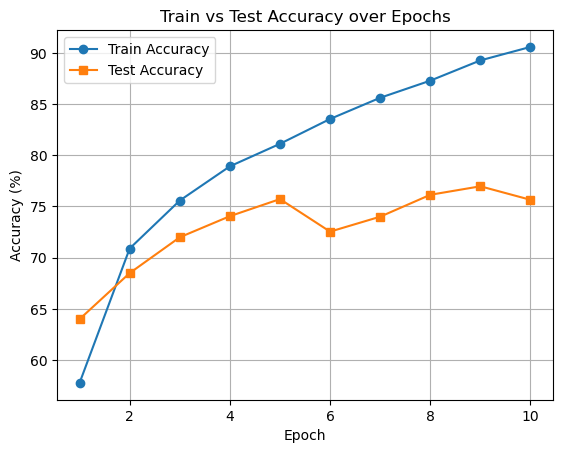

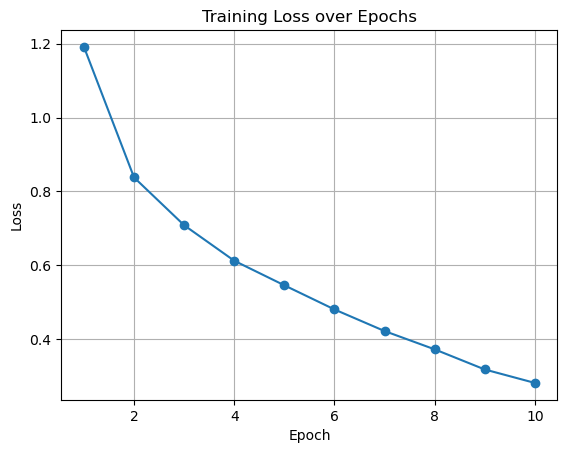

In [12]:
# Plot accuracy and loss vs. epochs
if 'train_accuracies' in globals() and 'test_accuracies' in globals() and 'train_losses' in globals():
    epochs = range(1, len(train_accuracies) + 1)
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, train_accuracies, marker='o', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, marker='s', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Train vs Test Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot training loss
    plt.figure()
    plt.plot(epochs, train_losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.show()
else:
    print("No training history found. Please run the training cell first.")